# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline ()
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)


UsageError: unrecognized arguments: ()


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
'''sample = pd.read_csv('sample_submission.csv') # пример ответа для kaggle
sample.head()'''

"sample = pd.read_csv('sample_submission.csv') # пример ответа для kaggle\nsample.head()"

In [4]:
data_train = pd.read_csv('../input/train.csv')
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
'''data_test = pd.read_csv('test.csv') # для kaggle
data_test.head()'''

"data_test = pd.read_csv('test.csv') # для kaggle\ndata_test.head()"

In [6]:
# разбиваем данные на train и на test
data_train_y = data_train['SalePrice'].copy()
data_train_x = data_train.drop('SalePrice', axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(data_train_x, data_train_y, test_size=0.3)  

In [8]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1022, 80), (1022,), (438, 80), (438,))

In [9]:
# Соединим train и test, для удобства обработки
X_valid['is_test'] = 1
X_train['is_test'] = 0

In [10]:
data = pd.concat([X_valid, X_train])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 830 to 369
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-

In [12]:
data.isnull().sum()[data.isnull().sum().values != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [13]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

In [14]:
# Разбиваем данные на категориальные и числовые
data_cat = data[cat_feat]

data_int = data.drop(cat_feat, axis=1)

In [15]:
# заполняем пропуски
data[data_cat.columns] = data_cat[data_cat.columns].fillna('NaN')
data[data_int.columns] = data[data_int.columns].fillna(0)

In [16]:
data.isnull().sum()[data.isnull().sum().values != 0]

Series([], dtype: int64)

In [17]:
# Обрабатываем категориальные переменные (при предположении что в test будут отличные значения,следовало бы обучаться только на train)
# Так же для каждого признака нужно было бы создать LabelEncoder, но в нашем примере можно этого не делать
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

for i  in data_cat.columns:
    if len(data[i].unique()) < 8:
        data = pd.get_dummies(data, columns=[i])
    else:
        le.fit(data[i])
        data[i] = le.transform(data[i])

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 830 to 369
Columns: 216 entries, Id to SaleCondition_Partial
dtypes: float64(3), int64(43), uint8(170)
memory usage: 778.5 KB


In [19]:
data.head(3)

,Id,MSSubClass,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,...,GarageType_NaN,GarageFinish_Fin,GarageFinish_NaN,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NaN,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NaN,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_NaN,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NaN,MiscFeature_Gar2,MiscFeature_NaN,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
830,831,20,80.0,11900,12,2,2,2,6,5,1957,1957,1,6,6,387.0,1040,0,352,1392,1392,0,0,1392,1,0,1,1,3,1,6,2,1957.0,2,458,0,0,0,0,192,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
454,455,90,63.0,9297,11,2,2,2,5,5,1976,1976,1,9,10,0.0,1606,0,122,1728,1728,0,0,1728,2,0,2,0,4,2,8,0,1976.0,2,560,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
563,564,50,66.0,21780,7,2,2,0,6,7,1918,1950,1,13,14,0.0,0,0,1163,1163,1163,511,0,1674,0,0,2,0,4,1,8,1,1955.0,2,396,72,36,0,0,144,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


In [20]:
# делим данные на трейн и тест
X_train = data[data.is_test==0]
X_valid = data[data.is_test==1]

X_train = X_train.drop('is_test', axis=1)
X_valid = X_valid.drop('is_test', axis=1)

In [21]:
# делаем нормирование
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_sc = std.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc, columns=X_train.columns)

X_valid_sc = std.transform(X_valid)
X_valid = pd.DataFrame(X_valid_sc, columns=X_train.columns)

In [22]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1022, 215), (1022,), (438, 215), (438,))

### Напоминаем задание

2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

###  Проверим как предсказывает модель на случайном лесе

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [24]:
clf_rf = RandomForestRegressor(n_jobs=-1, n_estimators=200)
max_depth = [5, 9, 13, 15]
min_samples_split = [10, 15, 25]
param_grid = {'max_depth': max_depth, 'min_samples_split': min_samples_split}

clf_rf = GridSearchCV(clf_rf, param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
clf_rf.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 9, 13, 15], 'min_samples_split': [10, 15, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [25]:
clf_rf_best = clf_rf.best_estimator_

In [26]:
y_pred_rf = clf_rf_best.predict(X_valid)

In [27]:
# Оценка по RandomForestRegressor
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_valid, y_pred_rf)
lin_rmse_rf = np.sqrt(lin_mse)
lin_rmse_rf

30496.942191025133

In [28]:
# Выводим важность признаков (TOP-5) 
imp = pd.Series(clf_rf_best.feature_importances_, index=X_train.columns)
imp.sort_values(ascending=False).head()

OverallQual    0.596479
GrLivArea      0.110857
2ndFlrSF       0.050878
BsmtFinSF1     0.027628
TotalBsmtSF    0.023480
dtype: float64

### 4. Реализуем стекинг

In [29]:
from sklearn.model_selection import StratifiedKFold

In [30]:
cv = StratifiedKFold(n_splits=10)

In [31]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float) 
    meta_test = np.zeros(X_test.shape[0], dtype=float) 
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)): 
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

### Первая модель для стекинга

In [32]:
from sklearn.linear_model import Lasso
lin_reg = Lasso()

In [33]:
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.]}
lasso_grid = GridSearchCV(lin_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [34]:
lasso_grid.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [35]:
lasso_grit_best = lasso_grid.best_estimator_

In [36]:
y_pred_lasso = lasso_grit_best.predict(X_valid)

In [37]:
lin_mse = mean_squared_error(y_valid, y_pred_lasso)
rmse_lasso = np.sqrt(lin_mse)
rmse_lasso

38757.800354468025

### Вторая модель для стекинга RandomForest которую реализовали ранее 

In [38]:
clf_rf_best = clf_rf.best_estimator_

In [39]:
y_pred_rf = clf_rf_best.predict(X_valid)

In [40]:
lin_mse = mean_squared_error(y_valid, y_pred_rf)
rmse_rf = np.sqrt(lin_mse)
rmse_rf

30496.94219102513

### Третья модель для стекинга

In [41]:
import xgboost as xgb

In [42]:
xgb_model_2 = xgb.XGBRegressor(n_estimators=30, n_jobs=-1)

In [43]:
# Подбор параметров закоментирован, так как слишком долго вычисляет
'''
max_depth = [2, 5, 7, 9]
colsample_bytree = [0.3, 0.6, 0.9, 1]
subsample = [0.3, 0.6, 0.9, 1]
gamma = [0, 0.3, 0.6, 0.8, 1]
alpha = [0, 0.3, 0.6, 0.9]
lamba = [0.1, 0.3, 0.6, 0.8, 1]

params = {
    'max_depth' : max_depth,
    'colsample_bytree' : colsample_bytree,
    'subsample' : subsample,
    'gamma' : gamma,
    'reg_alpha' : alpha,
    'reg_lambda' : lamba
}

gr_xgb = GridSearchCV(xgb_model_2, params, n_jobs=-1, cv=10, scoring='neg_mean_squared_error')
xgb_model = gr_xgb.fit(X_train, y_train)

xgb_model.best_params_

>>> 'colsample_bytree': 1,
>>> 'gamma': 0,
>>> 'max_depth': 5,
>>> 'reg_alpha': 0.6,
>>> 'reg_lambda': 0.1,
>>> 'subsample': 0.9
'''

"\nmax_depth = [2, 5, 7, 9]\ncolsample_bytree = [0.3, 0.6, 0.9, 1]\nsubsample = [0.3, 0.6, 0.9, 1]\ngamma = [0, 0.3, 0.6, 0.8, 1]\nalpha = [0, 0.3, 0.6, 0.9]\nlamba = [0.1, 0.3, 0.6, 0.8, 1]\n\nparams = {\n    'max_depth' : max_depth,\n    'colsample_bytree' : colsample_bytree,\n    'subsample' : subsample,\n    'gamma' : gamma,\n    'reg_alpha' : alpha,\n    'reg_lambda' : lamba\n}\n\ngr_xgb = GridSearchCV(xgb_model_2, params, n_jobs=-1, cv=10, scoring='neg_mean_squared_error')\nxgb_model = gr_xgb.fit(X_train, y_train)\n\nxgb_model.best_params_\n\n>>> 'colsample_bytree': 1,\n>>> 'gamma': 0,\n>>> 'max_depth': 5,\n>>> 'reg_alpha': 0.6,\n>>> 'reg_lambda': 0.1,\n>>> 'subsample': 0.9\n"

In [44]:
'''
xgb_model_3 = xgb.XGBRegressor(colsample_bytree=1, gamma=0, reg_alpha=0.6, reg_lambda=0.1,
                                   subsample=0.9, n_jobs=-1, n_estimators=5000, learning_rate=0.1)


learning_rate = [0.005, 0.007, 0.01]

fit_params={"early_stopping_rounds":50, 
            "eval_metric" : "rmse", 
            "eval_set" : [[X_train, y_train]]}

params = {
    'learning_rate' : learning_rate
}

gr_xgb_ = GridSearchCV(xgb_model_3, params, fit_params=fit_params, n_jobs=-1, cv=10, 
                       scoring='neg_mean_squared_error')

gr_xgb_.fit(X_train, y_train)

xgb_best = gr_xgb_.best_estimator_
print (xgb_best.best_ntree_limit)
print (gr_xgb_.best_params_)

>>> 5000
>>> {'learning_rate': 0.01}
'''

'\nxgb_model_3 = xgb.XGBRegressor(colsample_bytree=1, gamma=0, reg_alpha=0.6, reg_lambda=0.1,\n                                   subsample=0.9, n_jobs=-1, n_estimators=5000, learning_rate=0.1)\n\n\nlearning_rate = [0.005, 0.007, 0.01]\n\nfit_params={"early_stopping_rounds":50, \n            "eval_metric" : "rmse", \n            "eval_set" : [[X_train, y_train]]}\n\nparams = {\n    \'learning_rate\' : learning_rate\n}\n\ngr_xgb_ = GridSearchCV(xgb_model_3, params, fit_params=fit_params, n_jobs=-1, cv=10, \n                       scoring=\'neg_mean_squared_error\')\n\ngr_xgb_.fit(X_train, y_train)\n\nxgb_best = gr_xgb_.best_estimator_\nprint (xgb_best.best_ntree_limit)\nprint (gr_xgb_.best_params_)\n\n>>> 5000\n>>> {\'learning_rate\': 0.01}\n'

In [45]:
xgb_model_final = xgb.XGBRegressor(colsample_bytree=1, gamma=0, max_depth=5, reg_alpha=0.6, reg_lambda=0.1,
                                   subsample=0.9, n_jobs=-1, n_estimators=5000, learning_rate=0.01)

In [46]:
xgb_model_final.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.6,
       reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

In [47]:
y_pred_xgb = xgb_model_final.predict(X_valid)

In [48]:
rmse_xgb = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))
rmse_xgb

26455.74291976754

На этих трех моделях реализуем стекинг

In [49]:
all_models = [lasso_grit_best, clf_rf_best, xgb_model_final]

In [50]:
meta_train = []
meta_test = []
for i in all_models:
    meta_tr, meta_te = get_meta_features(i, X_train, y_train, X_valid, cv)
    meta_train.append(meta_tr)
    meta_test.append(meta_te)

    
col_names = ['lasso_model', 'rf_model', 'xgb_model']


In [51]:
X_train_meta = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_test_meta = pd.DataFrame(np.stack(meta_test,axis=1), columns=col_names)

In [52]:
X_train_meta.head(3)

,lasso_model,rf_model,xgb_model
0,186547.834937,189363.344209,174385.578125
1,135001.425209,137356.331732,137358.953125
2,203063.067237,188190.253370,192271.984375


### Напоминаем задание

5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

### Обучаем гипер модель (LinearRegression)

In [53]:
from sklearn.linear_model import LinearRegression
clf_lr_meta = LinearRegression(n_jobs=-1)

In [54]:
clf_lr_meta.fit(X_train_meta, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [55]:
yl_pred_meta_test = clf_lr_meta.predict(X_test_meta)

In [56]:
lin_mse = mean_squared_error(y_valid, yl_pred_meta_test)
rmse_stack = np.sqrt(lin_mse)
rmse_stack

26961.023913637913

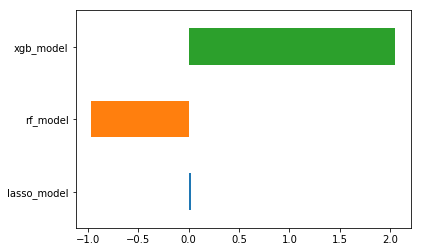

In [57]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_train_meta.columns).plot(kind='barh')

In [58]:
print ('Результат lasso_reg',rmse_lasso)
print ('Результат Lasso RandomForest',rmse_rf)
print ('Результат XGBoost',rmse_xgb)
print ('Результат stacking',rmse_stack)

Результат lasso_reg 38757.800354468025
Результат Lasso RandomForest 30496.94219102513
Результат XGBoost 26455.74291976754
Результат stacking 26961.023913637913
